### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [49]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [50]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Niranjana"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Niranjana"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Niranjana

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Niranjana

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [52]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke(messages)

In [53]:
result

AIMessage(content='Python is a great language to start with, especially for beginners. Here\'s a step-by-step guide to help you get started with Python programming:\n\n**1. Install Python**:\nDownload the latest version of Python from the official Python website (<https://www.python.org/downloads/>).\n\n**2. Choose a Text Editor or IDE**:\nA text editor or IDE (Integrated Development Environment) is where you\'ll write your Python code. Some popular choices include:\n * PyCharm (free community edition)\n * Visual Studio Code (free)\n * Sublime Text (free trial, paid version)\n * Atom (free)\n\n**3. Learn the Basics**:\nStart with basic Python concepts such as:\n * Variables\n * Data types (strings, integers, floats, booleans)\n * Operators\n * Control structures (if-else, for loops)\n * Functions\n * Modules and packages\n\n**4. Practice, Practice, Practice**:\nPractice writing Python code using online platforms, such as:\n * Codecademy (interactive coding lessons)\n * LeetCode (practi

In [54]:
result.response_metadata

{'token_usage': {'completion_tokens': 533,
  'prompt_tokens': 76,
  'total_tokens': 609,
  'completion_time': 0.70199732,
  'prompt_time': 0.013292566,
  'queue_time': 0.048739884,
  'total_time': 0.715289886},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_46fc01befd',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [39]:
def add(a: int, b: int) -> int:
    """Add two numbers together. Only use this tool when the user explicitly asks for mathematical addition.
    
    Args:
        a (int): first number to add
        b (int): second number to add
    
    Returns:
        int: the sum of a and b
    """
    return a + b


In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10ee7bad0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10f01fb90>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [55]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Nira")])

In [41]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'mk5fwb0ge',
  'type': 'tool_call'}]

### Using messages as state

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [14]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [15]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Niranjana"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Niranjana')]

In [16]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [17]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='228c2fba-ed6a-4a2e-a83f-6d6afd246339'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Niranjana', id='364dd912-2d36-4cf4-831b-fb31aadbf67a'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='6de767b8-1a1a-475a-8882-46febc1fba8f')]

In [18]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [61]:
from langchain_core.messages import SystemMessage

def llm_tool(state: State):
    messages = state["messages"]
    
    # Add system message if not present
    if not any(isinstance(msg, SystemMessage) for msg in messages):
        system_msg = SystemMessage(
            content="You are a knowledgeable AI assistant. Use your built-in knowledge to answer questions about various topics. Only use the 'add' tool when the user specifically requests mathematical addition (like 'what is 2 plus 2', 'add 5 and 3', 'calculate 10 + 15'). For all other questions, provide helpful answers using your training knowledge."
        )
        messages = [system_msg] + messages
    
    return {"messages": [llm_with_tools.invoke(messages)]}


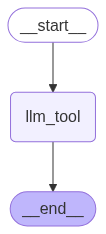

In [75]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [76]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (6wr3mye0t)
 Call ID: 6wr3mye0t
  Args:
    a: 2
    b: 2


In [77]:
tools=[add]

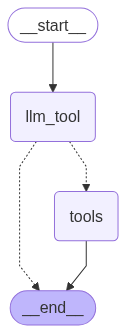

In [81]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [82]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (gbjsx332d)
 Call ID: gbjsx332d
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [80]:
messages=graph.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance on a task without being explicitly programmed.

There are several key concepts in machine learning, including:

1. **Supervised learning**: In this type of learning, the machine is trained on labeled data, where the correct output is provided for each input. The goal is to learn a mapping between inputs and outputs, so that the machine can make accurate predictions on new, unseen data.
2. **Unsupervised learning**: In this type of learning, the machine is trained on unlabeled data, and the goal is to discover patterns or relationships in the data.
3. **Reinforcement learning**: In this type of learning